In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import datetime as dt

train_data = pd.read_csv('/content/gdrive/MyDrive/fraudTrain.csv')
test_data = pd.read_csv('/content/gdrive/MyDrive/fraudTest.csv')
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)
train=train_data
test=test_data

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# fraud_data=train_data[train_data['is_fraud']==1]
# fraud_data['job'].unique()

# plt.figure(figsize=(10, 6))
# sns.countplot(data=fraud_data, x='job', hue='is_fraud')
# plt.xticks(rotation=90)
# plt.title('Job vs. Fraudulent Transactions')
# plt.show()

Text(0.5, 1.0, 'The Percentage of Fraudulent over Non-Fraudulent Transcations in Each city')

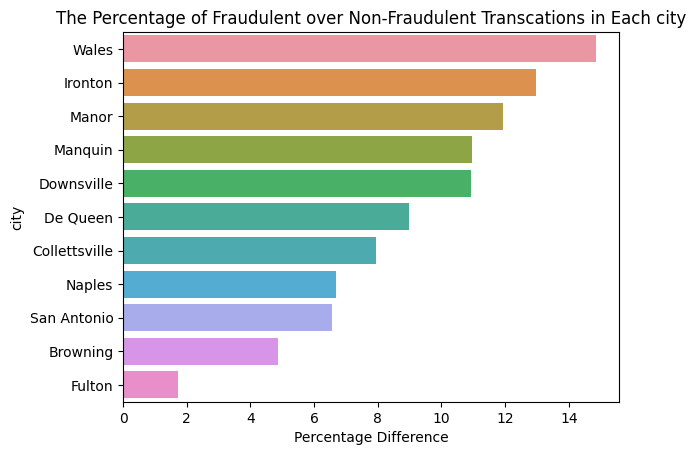

In [ ]:
a=train_data['city'][train_data.is_fraud==0].value_counts(normalize=True)
a=a.to_frame()
a=a.reset_index()
a.columns = ['city', 'Per']

b=train_data['city'][train_data.is_fraud==1].value_counts(normalize=True)
b=b.to_frame()
b=b.reset_index()
b.columns = ['city', 'Per']
merged=a.merge(b,on='city')
merged['diff']=merged['Per_y']-merged['Per_x']
merged['diff']=merged['diff']*100
merged=merged.sort_values('diff',ascending=False)

ax1=sns.barplot(data=merged, x='diff',y='city')
ax1.set_xlabel('Percentage Difference')
ax1.set_ylabel('city')
plt.title('The Percentage of Fraudulent over Non-Fraudulent Transcations in Each city')

In [4]:
train_data['month'] = pd.to_datetime(train_data['trans_date_trans_time']).dt.month
train_data['day'] = pd.to_datetime(train_data['trans_date_trans_time']).dt.dayofweek
train_data['hour'] = pd.to_datetime(train_data['trans_date_trans_time']).dt.hour
train_data['age'] = dt.date.today().year - pd.to_datetime(train_data['dob']).dt.year
train = train_data[['category','state' ,'amt','zip', 'lat', 'long', 'city_pop','merch_lat','merch_long','age', 'hour', 'day', 'month', 'is_fraud']]
# train

In [5]:
test_data['month'] = pd.to_datetime(test_data['trans_date_trans_time']).dt.month
test_data['day'] = pd.to_datetime(test_data['trans_date_trans_time']).dt.dayofweek
test_data['hour'] = pd.to_datetime(test_data['trans_date_trans_time']).dt.hour
test_data['age'] = dt.date.today().year - pd.to_datetime(test_data['dob']).dt.year
test = test_data[['category','state','amt','zip', 'lat', 'long','city_pop','merch_lat','merch_long','age', 'hour', 'day', 'month', 'is_fraud']]

In [ ]:
X_train_new, X_test_new = train_test_split(train, test_size=0.2, random_state=1)
Non_fraud_data = X_train_new[X_train_new['is_fraud'==0]]
X_new = Non_fraud_data.iloc[:, :-1].values



In [6]:


# all rows and all columns (except the last column)
X = train.iloc[:, :-1].values
# all rows and the last column => NOTE: storing all the result value
y = train.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [7]:
categorical_columns = [0,1]
numeric_columns = [2,3, 4, 5, 6, 7,8,9 , 10 ,11, 12]

# Use one-hot encoding for the 'category' column
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_columns)
])
# Apply preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)


In [8]:
# Apply SMOTE to the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

In [9]:
#isolation Forest
from sklearn.ensemble import IsolationForest
model3 = IsolationForest(n_estimators = 100, contamination = 0.03, max_samples ='auto')
model3.fit(X_train_resampled,y_train_resampled)

pipe3 = Pipeline(steps=[
    ('step1', preprocessor),
    ('step2', model3)
])

y_pred = pipe3.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.006732927220262905


In [15]:
#SVC implemented
from sklearn import svm
model4 =svm.SVC(kernel='linear')
model4.fit(X_train_resampled,y_train_resampled)

pipe4 = Pipeline(steps=[
    ('step1', preprocessor),
    ('step2', model4)
])

y_pred = pipe4.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9660147483167681


In [17]:
import pickle
pickle.dump(pipe4,open('pipe4.pkl','wb'))

In [ ]:
from sklearn.svm import OneClassSVM



In [24]:
print('Classification report:\n', classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      3096
         1.0       0.14      0.70      0.23        23

    accuracy                           0.97      3119
   macro avg       0.57      0.83      0.61      3119
weighted avg       0.99      0.97      0.98      3119

Confusion matrix:
 [[2997   99]
 [   7   16]]
Share of Non-Fraud in Test Data: 0.9926


###Logistic Regression

In [11]:
model1=LogisticRegression(solver='lbfgs', max_iter=400)


# pipe1.fit(X_train_resampled, y_train_resampled)
model1.fit(X_train_resampled, y_train_resampled)



LogisticRegression(max_iter=400)

In [12]:
import pickle
pickle.dump(model1,open('logisticRegression.pkl','wb'))

In [ ]:
pipe1 = Pipeline(steps=[
    ('step1', preprocessor),
    ('step2', model1)
])

In [ ]:
# Predict using the logistic regression model
# X_test_transformed = preprocessor.fit_transform(X_test)

# Make predictions using the pipeline
# y_pred = pipe1.predict(X_test_transformed)
y_pred = pipe1.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9644116704071818


In [ ]:
fraudulent_samples = train[train['is_fraud'] == 1]
fraudulent_samples=fraudulent_samples[0:5]
fraudulent_samples=fraudulent_samples.iloc[:, :-1]
fraudulent_samples

,category,state,amt,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,day,month
2449,grocery_pos,NC,281.06,28611,35.9946,-81.7266,885,36.430124,-81.179483,35,1,2,1
2472,gas_transport,TX,11.52,78208,29.4400,-98.4590,1595797,29.819364,-99.142791,63,1,2,1
2523,grocery_pos,TX,276.31,78208,29.4400,-98.4590,1595797,29.273085,-98.836360,63,3,2,1
2546,gas_transport,NC,7.03,28611,35.9946,-81.7266,885,35.909292,-82.091010,35,3,2,1
2553,grocery_pos,TX,275.73,78208,29.4400,-98.4590,1595797,29.786426,-98.683410,63,3,2,1


In [ ]:
y_pred = pipe1.predict(fraudulent_samples)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


In [ ]:
y_pred

array([1., 1., 1., 1., 1.])

In [ ]:
# X_t = test.iloc[:, :-1].values
# y_t = test.iloc[:, -1].values
# X_test_transformed = preprocessor.transform(X_t)
# y_pred = pipe1.predict(X_test_transformed)
# y_pred
# accuracy = accuracy_score(y_t, y_pred)
# print(f"Accuracy: {accuracy}")

Accuracy: 0.9595661382452988


###Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
model2=RandomForestClassifier()


model2.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

In [14]:
import pickle
pickle.dump(model2,open('RandomForest.pkl','wb'))

In [ ]:
pipe2 = Pipeline(steps=[
    ('step1', preprocessor),
    ('step2', model2)
])

In [ ]:
# Predict using the logistic regression model
# X_test_transformed = preprocessor.fit_transform(X_test)

# Make predictions using the pipeline
# y_pred = pipe2.predict(X_test_transformed)
y_pred = pipe2.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9980763065084963


In [ ]:
import pickle
pickle.dump(pipe1,open('pipe1.pkl','wb'))

In [ ]:
pickle.dump(pipe2,open('pipe2.pkl','wb'))

In [ ]:
train.head()

,category,state,amt,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,day,month,is_fraud
0,misc_net,NC,4.97,28654,36.0788,-81.1781,3495,36.011293,-82.048315,35,0,1,1,0.0
1,grocery_pos,WA,107.23,99160,48.8878,-118.2105,149,49.159047,-118.186462,45,0,1,1,0.0
2,entertainment,ID,220.11,83252,42.1808,-112.2620,4154,43.150704,-112.154481,61,0,1,1,0.0
3,gas_transport,MT,45.00,59632,46.2306,-112.1138,1939,47.034331,-112.561071,56,0,1,1,0.0
4,misc_pos,VA,41.96,24433,38.4207,-79.4629,99,38.674999,-78.632459,37,0,1,1,0.0


In [ ]:
train['category'].unique()

array(['misc_net', 'grocery_pos', 'entertainment', 'gas_transport',
       'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos',
       'food_dining', 'personal_care', 'health_fitness', 'travel',
       'kids_pets', 'home'], dtype=object)

In [ ]:
train['state'].unique()

array(['NC', 'WA', 'ID', 'MT', 'VA', 'PA', 'KS', 'TN', 'IA', 'WV', 'FL',
       'CA', 'NM', 'NJ', 'OK', 'IN', 'MA', 'TX', 'WI', 'MI', 'WY', 'HI',
       'NE', 'OR', 'LA', 'DC', 'KY', 'NY', 'MS', 'UT', 'AL', 'AR', 'MD',
       'GA', 'ME', 'AZ', 'MN', 'OH', 'CO', 'VT', 'MO', 'SC', 'NV', 'IL',
       'NH', 'SD', 'AK', 'ND', 'CT', 'RI'], dtype=object)